In [1]:
# compare Hazem/Christof's with Burke's temperature data

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import tc_cost.util.constants as u_const
import tc_cost.util.data as u_data
import tc_cost.bootstrap.scc as bs_scc

In [2]:
with xr.open_dataset(u_const.GMT_NC) as _ds:
    ds_gmt = _ds.sel(rcp="rcp26").compute().copy()

fig = plt.figure()
ax = fig.gca()

for gcm in ds_gmt["gcm"].values:
    _da = ds_gmt["gmt"].sel(gcm=gcm)
    ax.plot(_da["year"], _da.values)

fig.tight_layout()

In [3]:
ds_temp = {
    "hazem": u_data.load_hist_temp(source="hazem"),
    "burke": u_data.load_hist_temp(source="burke"),
    "christof": u_data.load_hist_temp(source="gswp3-w5e5"),
    "proj": bs_scc.load_poptemp(),
}
ref_temp_src = "christof"

[hazem] Set missing BRB temperatures to TTO's temperatures...
[hazem] Set missing LCA temperatures to TTO's temperatures...
[hazem] Set missing TON temperatures to WSM's temperatures...
[hazem] Set missing HKG temperatures to VNM's temperatures...
[burke] Set missing BRB temperatures to TTO's temperatures...
[burke] Set missing LCA temperatures to TTO's temperatures...
[burke] Set missing TON temperatures to WSM's temperatures...
[burke] Set missing HKG temperatures to VNM's temperatures...


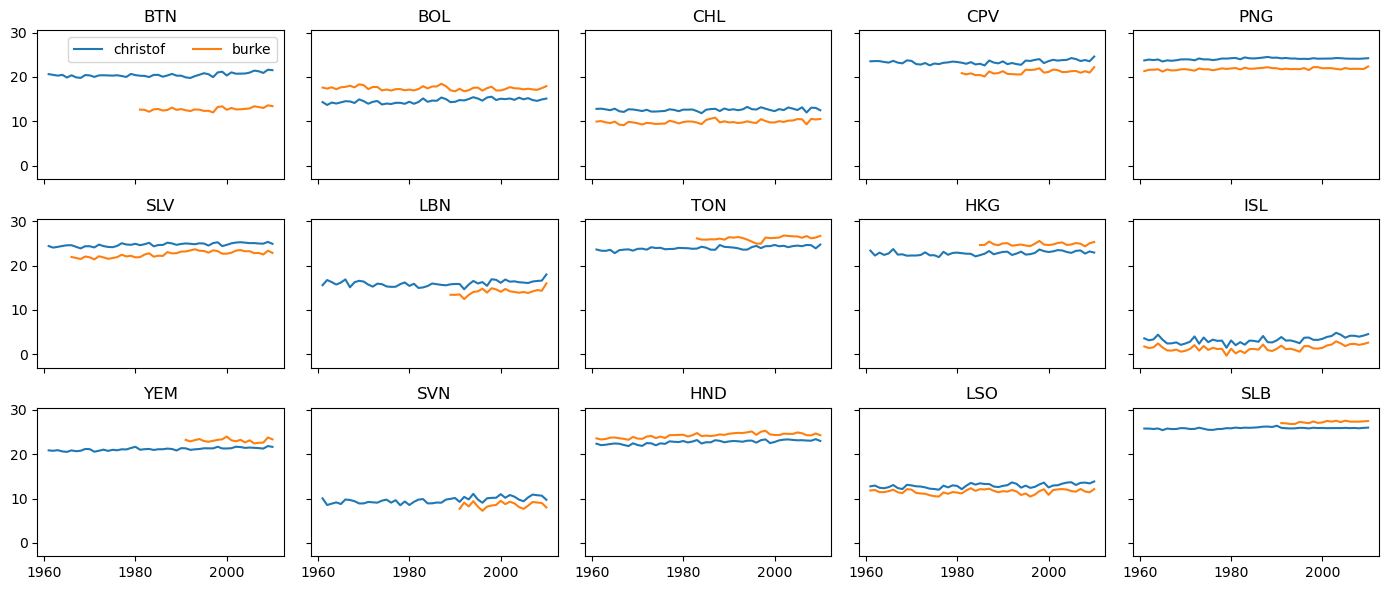

In [4]:
fig = plt.figure(figsize=(14, 6))
axs = fig.subplots(3, 5, sharex=True, sharey=True)
ds_tdiff = ((ds_temp[ref_temp_src] - ds_temp["burke"])**2).mean(dim="year")
countries = ds_tdiff["ISO"].sortby(ds_tdiff["temp"], ascending=False).values[:15]
for i_ax, (ax, iso) in enumerate(zip(axs.ravel(), countries)):
    for label in [ref_temp_src, "burke"]:
        ds = ds_temp[label].sel(year=range(1961, 2011))
        ax.plot(
            ds["year"].values, ds.sel(ISO=iso)["temp"].values,
            label=label,
        )
    ax.set_title(iso)
    ax.set_ylim(-3, 30.5)
    if i_ax == 0:
        ax.legend(ncol=2)
fig.tight_layout()

In [5]:
fig = plt.figure(figsize=(12, 20))
axs = fig.subplots(10, 3, sharey=True, sharex=True)

top10_ctry = (
    np.abs(ds_temp[ref_temp_src]["temp"] - ds_temp["proj"]["poptemp"])
    .mean(dim="year")
    .max(dim=["gcm", "rcp"])
    .to_series()
    .sort_values(ascending=False)
    .index[:10]
)

for i_ax, iso in enumerate(top10_ctry):
    for j_ax, rcp in enumerate(["rcp26", "rcp60", "rcp85"]):
        ax = axs[i_ax, j_ax]
        ax.set_title(f"{iso}, {rcp}")

        ds = ds_temp[ref_temp_src].sel(ISO=iso)
        ax.plot(
            ds["year"].values, ds["temp"].values,
            color="black", label=ref_temp_src,
        )

        ds_proj = ds_temp["proj"].sel(rcp=rcp, ISO=iso)
        for gcm in ds_proj["gcm"].values:
            ds = ds_proj.sel(gcm=gcm)
            ax.plot(
                ds["year"].values,
                ds["poptemp"].values,
                label=gcm,
            )
        ax.set_ylim(-3, 30.5)
        if i_ax == 0 and j_ax == 0:
            ax.legend(ncol=2)
fig.tight_layout()

In [6]:
for key in ["christof", "hazem"]:
    print(f"Countries in Burke, but not in {key.capitalize()}: " + (
        ", ".join(np.setdiff1d(ds_temp["burke"]["ISO"].values, ds_temp[key]["ISO"]))
    ))
for key in ["christof", "hazem", "proj"]:
    print(f"Countries in {key.capitalize()}, but not in Burke: " + (
        ", ".join(np.setdiff1d(ds_temp[key]["ISO"].values, ds_temp["burke"]["ISO"]))
    ))
for key, _ds in ds_temp.items():
    print(f"TC-affected countries not in {key.capitalize()}: " + (
        ", ".join(np.setdiff1d(u_const.L_COUNTRIES, _ds["ISO"].values))
    ))

Countries in Burke, but not in Christof: 
Countries in Burke, but not in Hazem: 
Countries in Christof, but not in Burke: JAM, MMR, NCL, TWN
Countries in Hazem, but not in Burke: JAM, MMR, NCL, TWN
Countries in Proj, but not in Burke: JAM, MMR, NCL, TWN
TC-affected countries not in Hazem: 
TC-affected countries not in Burke: JAM, MMR, NCL, TWN
TC-affected countries not in Christof: 
TC-affected countries not in Proj: 
